In [1]:
import pickle

# Load meta dict

with open('../../PNC/MegaMeta.bin', 'rb') as f:
    meta = pickle.load(f)
    
print(len(list(meta.keys())))

941


In [2]:
# Load splits

with open('../../Work/Explainer/Splits/EmoidNbackWrat10FoldCV.pkl', 'rb') as f:
    splits = pickle.load(f)

print('Finished')

Finished


In [3]:
import numpy as np

len(np.concatenate([splits[0][0],splits[0][1]]))

620

In [4]:
def getTrainTestIdcs(splits, splitId, makeTorch=True):
    lookup = dict()
    allSplit0Ids = np.concatenate([splits[0][0],splits[0][1]])
    for i in range(620):
        lookup[allSplit0Ids[i]] = i
    trainIdcs = []
    testIdcs = []
    for key in splits[splitId][0]:
        trainIdcs.append(lookup[key])
    for key in splits[splitId][1]:
        testIdcs.append(lookup[key])
    trainIdcs = np.array(trainIdcs)
    testIdcs = np.array(testIdcs)
    if makeTorch:
        trainIdcs = torch.from_numpy(trainIdcs).cuda()
        testIdcs = torch.from_numpy(testIdcs).cuda()
    return trainIdcs, testIdcs

getTrainTestIdcs(splits, 4, False)

(array([  0,   1,   3,   5,   6,   7,   9,  10,  11,  12,  13,  14,  15,
         16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  28,  29,  30,
         31,  32,  33,  34,  35,  36,  37, 558,  38,  39,  40,  41,  42,
         43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  55,  56,
         57,  58,  60,  61,  62,  63,  64,  65,  67,  68,  69,  70,  72,
        559,  73,  75,  76,  77,  78, 560,  79,  80,  81,  82,  83, 561,
         84,  85,  86,  87, 562,  88,  89,  90,  91,  92,  93,  94,  95,
         96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 107, 108, 109,
        563, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
        122, 123, 124, 125, 126, 127, 128, 129, 564, 131, 132, 133, 134,
        135, 136, 137, 138, 565, 139, 140, 141, 142, 143, 144, 145, 566,
        567, 146, 147, 568, 148, 149, 150, 151, 152, 153, 154, 155, 156,
        157, 158, 160, 161, 162, 163, 166, 167, 168, 169, 170, 569, 171,
        172, 173, 570, 174, 175, 176, 571, 177, 178

In [5]:
p_nback = np.zeros([620,264,264])
p_emoid = np.zeros([620,264,264])
ages = np.zeros([620])

split0Ids = np.concatenate([splits[0][0],splits[0][1]])

for i in np.arange(620):
    subId = split0Ids[i]
    p_nback[i] = np.corrcoef(meta[subId]['nbackData'])
    p_emoid[i] = np.corrcoef(meta[subId]['emoidData'])
    ages[i] = int(meta[subId]['meta']['AgeInMonths'])/12
    if i % 100 == 0:
        print(f'Finished {i}')
        
print(f'Finished train {i}')

Finished 0
Finished 100
Finished 200
Finished 300
Finished 400
Finished 500
Finished 600
Finished train 619


In [7]:
# Convert to torch

import torch

p_nback_t = torch.from_numpy(p_nback).reshape(-1,264*264).float().cuda()
p_emoid_t = torch.from_numpy(p_emoid).reshape(-1,264*264).float().cuda()
ages_t = torch.from_numpy(ages).float().cuda()

print('Complete')

Complete


In [8]:
feat_t = torch.cat([p_nback_t, p_emoid_t], dim=1)

print(feat_t.shape)

torch.Size([620, 139392])


In [43]:
# Get the adjacency matrix

trainIdcs, testIdcs = getTrainTestIdcs(splits, 2, True)

def normalize(A):
    if A.shape[0] != A.shape[1]:
        raise Exception("Bad A shape")
    d = torch.sum(A,dim=1)**0.5
    return ((A/d).T/d).T

# Cosine similarity
def calcEdges(ps1, ps2):
    nB = ps1.shape[0]
    e = torch.einsum('ai,bi->ab',ps1,ps2)
    F1 = torch.einsum('ai,ai->a',ps1,ps1)**0.5
    F2 = torch.einsum('ai,ai->a',ps2,ps2)**0.5
    e /= F1.unsqueeze(1)
    e /= F2.unsqueeze(1).T
#     e = torch.einsum('aij,bij->ab',ps1,ps2)
#     F1 = torch.einsum('aij,aij->a',ps1,ps1)**0.5
#     F2 = torch.einsum('aij,aij->a',ps2,ps2)**0.5
#     e /= F1.unsqueeze(1)
#     e /= F2.unsqueeze(1).T
    return normalize(e-torch.eye(nB).float().cuda())

AtrainNN = calcEdges(feat_t[trainIdcs,0:264*264], feat_t[trainIdcs,0:264*264]) + torch.eye(558).float().cuda()
AtrainNE = calcEdges(feat_t[trainIdcs,0:264*264], feat_t[trainIdcs,264*264:]) + torch.eye(558).float().cuda()
AtrainEE = calcEdges(feat_t[trainIdcs,264*264:], feat_t[trainIdcs,264*264:]) + torch.eye(558).float().cuda()
Atrain = calcEdges(feat_t[trainIdcs], feat_t[trainIdcs]) + torch.eye(558).float().cuda()

ANN = calcEdges(feat_t[:,0:264*264], feat_t[:,0:264*264]) + torch.eye(620).float().cuda()
ANE = calcEdges(feat_t[:,0:264*264], feat_t[:,264*264:]) + torch.eye(620).float().cuda()
AEE = calcEdges(feat_t[:,264*264:], feat_t[:,264*264:]) + torch.eye(620).float().cuda()
A = calcEdges(feat_t, feat_t) + torch.eye(620).float().cuda()

print(AtrainNN.shape)
print(AtrainNE.shape)
print(AtrainEE.shape)
print(Atrain.shape)
print(ANN.shape)
print(ANE.shape)
print(AEE.shape)
print(A.shape)

torch.Size([558, 558])
torch.Size([558, 558])
torch.Size([558, 558])
torch.Size([558, 558])
torch.Size([620, 620])
torch.Size([620, 620])
torch.Size([620, 620])
torch.Size([620, 620])


In [44]:
# Train the model

import torch.nn as nn
import torch.nn.functional as F

class GCN2(nn.Module):
    def __init__(self):
        super(GCN2, self).__init__()
        self.gc1NN = nn.Linear(2*264*264,50).float().cuda()
        self.gc2NN = nn.Linear(50,5).float().cuda()
        self.gc1NE = nn.Linear(2*264*264,50).float().cuda()
        self.gc2NE = nn.Linear(50,5).float().cuda()
        self.gc1EE = nn.Linear(2*264*264,50).float().cuda()
        self.gc2EE = nn.Linear(50,5).float().cuda()
        self.fc1 = nn.Linear(15,1).float().cuda()
#         self.loss = nn.CrossEntropyLoss()
        self.loss = nn.MSELoss()
        
    def forward(self, x):
        A = x[0]
        B = x[1]
        C = x[2]
        z = x[3]
        a = A@z
        a = F.relu(self.gc1NN(a))
        a = A@a
        a = self.gc2NN(a)
        b = B@z
        b = F.relu(self.gc1NE(b))
        b = B@b
        b = self.gc2NE(b)
        c = C@z
        c = F.relu(self.gc1EE(c))
        c = A@c
        c = self.gc2EE(c)
        x = self.fc1(torch.cat([a,b,c], dim=1))
        return x
    
gcn2 = GCN2()
optim = torch.optim.Adam(gcn2.parameters(), lr=2e-5, weight_decay=0.2)

nEpoch = 4000
pPrint = 200

ages_t_train = ages_t[trainIdcs]
feat_t_train = feat_t[trainIdcs]

for epoch in range(nEpoch):
    optim.zero_grad()
    pred = gcn2([AtrainNN,AtrainNE,AtrainEE,feat_t_train]).flatten()
    loss = gcn2.loss(pred, ages_t_train)
    loss.backward()
    optim.step()
    if epoch % pPrint == 0 or epoch == nEpoch-1:
        print(f'epoch {epoch} loss={loss}')
        
print('Complete')

epoch 0 loss=224.0835418701172
epoch 200 loss=8.241705894470215
epoch 400 loss=5.599492073059082
epoch 600 loss=4.1591010093688965
epoch 800 loss=3.0990190505981445
epoch 1000 loss=2.478087902069092
epoch 1200 loss=1.9844776391983032
epoch 1400 loss=1.599553108215332
epoch 1600 loss=1.3199256658554077
epoch 1800 loss=1.099527359008789
epoch 2000 loss=0.8981927037239075
epoch 2200 loss=1.089066743850708
epoch 2400 loss=0.6375507116317749
epoch 2600 loss=0.6979003548622131
epoch 2800 loss=0.4642910361289978
epoch 3000 loss=0.41295114159584045
epoch 3200 loss=0.3571791350841522
epoch 3400 loss=0.3333374261856079
epoch 3600 loss=0.2974158525466919
epoch 3800 loss=0.2692790925502777
epoch 3999 loss=0.2582586407661438
Complete


In [45]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2*264*264,100).float().cuda()
        self.fc2 = nn.Linear(100,1).float().cuda()
        self.loss = nn.MSELoss()
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
mlp = MLP()
optim = torch.optim.Adam(mlp.parameters(), lr=1e-4, weight_decay=0.2)

nEpoch = 1000
pPrint = 200

for epoch in range(nEpoch):
    optim.zero_grad()
    pred = mlp(feat_t_train).flatten()
    loss = mlp.loss(pred, ages_t_train)
    loss.backward()
    optim.step()
    if epoch % pPrint == 0 or epoch == nEpoch-1:
        print(f'epoch {epoch} loss={loss}')
        
print('Complete')

epoch 0 loss=236.6566925048828
epoch 200 loss=1.7980469465255737
epoch 400 loss=0.6283798217773438
epoch 600 loss=0.21678049862384796
epoch 800 loss=0.17437562346458435
epoch 999 loss=0.09621638804674149
Complete


In [46]:
# Train the model

import torch.nn as nn
import torch.nn.functional as F

class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.gc1 = nn.Linear(2*264*264,50).float().cuda()
        self.gc2 = nn.Linear(50,1).float().cuda()
#         self.loss = nn.CrossEntropyLoss()
        self.loss = nn.MSELoss()
        
    def forward(self, x):
        A = x[0]
        x = A@x[1]
        x = F.relu(self.gc1(x))
        x = A@x
        x = self.gc2(x)
        return x
    
gcn = GCN()
optim = torch.optim.Adam(gcn.parameters(), lr=2e-5, weight_decay=0.2)

nEpoch = 4000
pPrint = 200

ages_t_train = ages_t[trainIdcs]
feat_t_train = feat_t[trainIdcs]

for epoch in range(nEpoch):
    optim.zero_grad()
    pred = gcn([Atrain,feat_t_train]).flatten()
    loss = gcn.loss(pred, ages_t_train)
    loss.backward()
    optim.step()
    if epoch % pPrint == 0 or epoch == nEpoch-1:
        print(f'epoch {epoch} loss={loss}')
        
print('Complete')

epoch 0 loss=236.995849609375
epoch 200 loss=9.571003913879395
epoch 400 loss=6.316831588745117
epoch 600 loss=4.787312984466553
epoch 800 loss=3.79618239402771
epoch 1000 loss=3.2726643085479736
epoch 1200 loss=2.5275704860687256
epoch 1400 loss=2.079885721206665
epoch 1600 loss=1.7063813209533691
epoch 1800 loss=1.3988287448883057
epoch 2000 loss=1.152025580406189
epoch 2200 loss=0.9576355814933777
epoch 2400 loss=0.7788711786270142
epoch 2600 loss=0.6425278186798096
epoch 2800 loss=0.5363619923591614
epoch 3000 loss=0.44374513626098633
epoch 3200 loss=0.36966970562934875
epoch 3400 loss=0.3482189476490021
epoch 3600 loss=0.30341726541519165
epoch 3800 loss=0.23844657838344574
epoch 3999 loss=0.2611254155635834
Complete


[[1.         0.80164616]
 [0.80164616 1.        ]]
1.9133619622449052
1.5141252
[[1.         0.76556281]
 [0.76556281 1.        ]]
2.075660448791068
1.5924006
[[1.         0.79981078]
 [0.79981078 1.        ]]
1.918038858348232
1.5315787


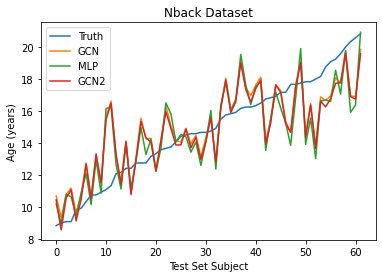

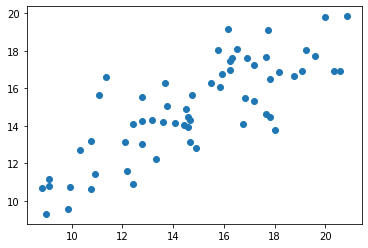

In [47]:
import matplotlib.pyplot as plt

pred = gcn([A,feat_t]).flatten()[testIdcs]
pred2 = mlp(feat_t).flatten()[testIdcs]
pred3 = gcn2([ANN,ANE,AEE,feat_t]).flatten()[testIdcs]
y = ages_t[testIdcs].detach().cpu().numpy()
idcs = np.argsort(y)
y = y[idcs]
pred = pred.detach().cpu().numpy()[idcs]
pred2 = pred2.detach().cpu().numpy()[idcs]
pred3 = pred3.detach().cpu().numpy()[idcs]

corr = np.corrcoef(y, pred)
rmse = np.mean((y-pred)**2)**0.5
mae = np.mean(np.abs(y-pred))

print(corr)
print(rmse)
print(mae)

corr = np.corrcoef(y, pred2)
rmse = np.mean((y-pred2)**2)**0.5
mae = np.mean(np.abs(y-pred2))

print(corr)
print(rmse)
print(mae)

corr = np.corrcoef(y, pred3)
rmse = np.mean((y-pred3)**2)**0.5
mae = np.mean(np.abs(y-pred3))

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(pred, label='GCN')
plt.plot(pred2, label='MLP')
plt.plot(pred3, label='GCN2')
plt.legend()
plt.xlabel('Test Set Subject')
plt.ylabel('Age (years)')
plt.title('Nback Dataset')
plt.show()

plt.scatter(y, pred)
plt.show()

In [33]:
# Explain decision for a graph

class Explainer(nn.Module):
    def __init__(self):
        super(Explainer, self).__init__()
        self.Amask = nn.Parameter(torch.ones(620,620).float().cuda())
        self.fmask = nn.Parameter(torch.ones(264*264).float().cuda())
        
    def forward(self, x):
        Amask = torch.sigmoid(self.Amask)
        fmask = torch.sigmoid(self.fmask)
        A = x[0]*Amask
        feat = x[1]*fmask.expand(620,264*264)
        model = x[2]
        pred = model([A,feat]).flatten()
        return pred
        
    def loss(self, testIdcs, truth, pred, A):
        Amask = torch.sigmoid(self.Amask)
        fmask = torch.sigmoid(self.fmask)
        pred_loss = torch.mean((truth-pred)**2)
        size_loss = torch.sum(Amask)
        feat_size_loss = torch.sum(fmask)
        mask_ent_loss = torch.mean(-Amask*torch.log(Amask) - (1-Amask)*torch.log(1-Amask))
        feat_ent_loss = torch.mean(-fmask*torch.log(fmask) - (1-fmask)*torch.log(1-fmask))
        m_adj = Amask*A
        D = torch.diag(torch.sum(m_adj, dim=0))
        L = D - m_adj
        lap_loss = pred.T @ L @ pred
        return pred_loss + 10e0*size_loss + 5.05e5*mask_ent_loss + 1e-4*feat_size_loss + 5*feat_ent_loss + lap_loss
    
nEpoch = 100
pPrint = 20

exp = Explainer()
optim = torch.optim.Adam(exp.parameters(), lr=1e-1, weight_decay=0)
feat = p_t.reshape(-1,264*264)

for epoch in range(nEpoch):
    optim.zero_grad()
    pred = exp([A,feat,gcn])
    loss = exp.loss(testIdcs, labels_t, pred, A)
    loss.backward()
    optim.step()
    if epoch % pPrint == 0 or epoch == nEpoch-1:
        print(f'epoch {epoch} loss={loss}')
        
print('Complete')

epoch 0 loss=3104893.25
epoch 20 loss=1288629.875
epoch 40 loss=335254.78125
epoch 60 loss=144742.890625
epoch 80 loss=90674.9140625
epoch 99 loss=66954.75
Complete


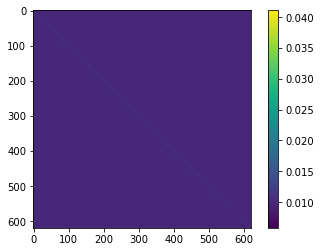

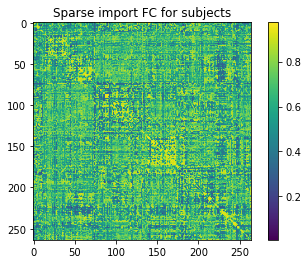

In [34]:
import matplotlib.pyplot as plt

Am = torch.sigmoid(exp.Amask).detach().cpu().numpy()
fm = torch.sigmoid(exp.fmask).reshape(264,264).detach().cpu().numpy()

plt.imshow(Am)
plt.colorbar()
# plt.title('Sparse Subject-Subject Population Graph')
plt.show()

# plt.plot(Am[nodeIdx,:])
# plt.title(f'Row for Explained Subject {nodeIdx}')
# plt.show()

# plt.plot(Am[nodeIdx+14,:])
# plt.title(f'Row for Unexplained Subject {nodeIdx+14}')
# plt.show()

plt.imshow(fm)
plt.colorbar()
plt.title(f'Sparse import FC for subjects')
plt.show()

In [35]:
Am[0:3,0:3]

array([[0.00738107, 0.00984113, 0.00984702],
       [0.00983996, 0.0093024 , 0.00984906],
       [0.00984165, 0.00984625, 0.0161497 ]], dtype=float32)